In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from scipy.stats import zscore

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-29-ontogeny_males_raw_usage_df_beh_age.parquet').astype(float)
#male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_males_raw_usage_df_beh_age.parquet').astype(float)
male_df = male_df[keep_syllables]
# for female:# for female:
m_df= male_df.groupby(['age','uuid']).mean()

In [6]:
# avarage per age or session
m_df = m_df.sort_index(level='age')
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

## heatmaps

In [7]:
format_plots()

In [8]:
## male heatmap

In [9]:
# get distance
data=avg_m_norm # 
dist_matrix = squareform(pdist(data,metric='cosine'))
data_labels=data.index.get_level_values('age').to_numpy()

percentiles_up = [95]
percentiles_down = [5]
#vmax_value = np.percentile(dist_matrix, percentiles_up)
#vmin_value = np.percentile(dist_matrix, percentiles_down)
vmax_value=0.60556295
vmin_value = 0.03662301

In [10]:
#colors for plotting
cmap2 = cmm
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='magma_r'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

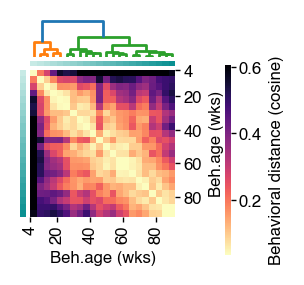

In [11]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=dist_matrix,
    cmap=seqmatcolor, 
    figsize=(1.3, 1.3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=ages,
    xticklabels=ages,
    cbar_kws={'label': 'Behavioral distance (cosine)'}, 
    vmin=vmin_value,
    vmax=vmax_value,
    rasterized=True,
    )
cg.ax_row_dendrogram.set_visible(False)
# Perform hierarchical clustering
col_linkage = linkage(avg_m_df, method='ward')
# Add the column dendrogram
col_dendrogram_data = dendrogram(col_linkage, ax=cg.ax_col_dendrogram, orientation='top', no_labels=True)
cg.ax_col_dendrogram.set_visible(True)
ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Beh.age (wks)')
ax.set_ylabel('Beh.age (wks)')


# Desired tick labels
desired_ages = [4, 20, 40, 60, 80]
# Find the positions of the desired ages
tick_positions = [np.where(data_labels == age)[0][0] for age in desired_ages]
tick_labels = desired_ages

# Set x and y ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)
# legend
#for i,c in enumerate(colors):
#        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
#plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [12]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ '07_24_male_dist_matrix_minmax_cosine_beh_age.pdf')

In [13]:
## female average

In [14]:
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/2024-07-29-ontogeny_females_raw_usage_df_beh_age.parquet').astype(float)
#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_females_raw_usage_df_beh_age.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()

In [15]:
# avarage per age or session
m_df = f_df.sort_index(level='age')
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# zscore
z_m = m_df.apply(zscore, axis=0)
avg_z_m = avg_m_df.apply(zscore, axis=0)

# log
m_log = np.log(m_df+1e-3)
avg_m_log = np.log(avg_m_df+1e-3)

# log and z_score
z_log = m_log.apply(zscore, axis=0)
avg_z_log = avg_m_log.apply(zscore, axis=0)


# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [16]:
# get distance
data=avg_m_norm # un-normalized
dist_matrix = squareform(pdist(data,metric='cosine'))
data_labels=data.index.get_level_values('age').to_numpy()

percentiles_up = [95]
percentiles_down = [5]
#vmax_value = np.percentile(dist_matrix, percentiles_up)
#vmin_value = np.percentile(dist_matrix, percentiles_down)

In [17]:
#colors for plotting
cmap2 = cmf
ages = np.unique(data_labels)
colors = np.int_(np.arange(0, 256, 256/len(ages)))
seqmatcolor='magma_r'

# create age labels colors
lines=[]
counter = Counter(data_labels)
sorted(counter.items())
a=np.array([*counter.values()])

color_mat=[]
n=0
for i,c in enumerate(colors):
    for j in range(a[i]):
        color_mat.append(cmap2(c))

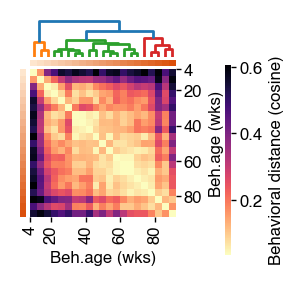

In [18]:
# plot syllable usage acoss time points
cg=sns.clustermap(
    data=dist_matrix,
    #data=squareform(pdist(data,metric='cosine')),
    cmap=seqmatcolor, 
    figsize=(1.3, 1.3),
    col_colors=color_mat,
    row_colors=color_mat,
    cbar_pos=(1.02, 0.025, 0.025, .73),
    col_cluster=False,
    row_cluster=False,
    yticklabels=ages,
    xticklabels=ages,
    cbar_kws={'label': 'Behavioral distance (cosine)'}, 
    vmin=vmin_value,
    vmax=vmax_value,
    rasterized=True,
    )
cg.ax_row_dendrogram.set_visible(False)

# Perform hierarchical clustering
col_linkage = linkage(avg_m_df, method='ward')
# Add the column dendrogram
col_dendrogram_data = dendrogram(col_linkage, ax=cg.ax_col_dendrogram, orientation='top', no_labels=True)
cg.ax_col_dendrogram.set_visible(True)

ax = cg.ax_heatmap
#ax.tick_params(left=False, bottom=False, right=False)
ax.set_xlabel('Beh.age (wks)')
ax.set_ylabel('Beh.age (wks)')


# Desired tick labels
desired_ages = [4, 20, 40, 60, 80]
# Find the positions of the desired ages
tick_positions = [np.where(data_labels == age)[0][0] for age in desired_ages]
tick_labels = desired_ages

# Set x and y ticks and labels
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

# legend
#for i,c in enumerate(colors):
#        lines.append(Line2D([0], [0], color=cmap2(c), lw=2))
#plt.legend(handles=lines,labels=list(ages),bbox_to_anchor=(10, 1),loc='upper right',fontsize=6)
plt.show()

In [19]:
c = PlotConfig()
cg.savefig(c.dana_save_path / "fig2"/ '07_24_female_dist_matrix_minmax_cosine_beh_age.pdf')